In [ ]:
!pip install --upgrade bezier --no-binary=bezier

In [621]:
!pip install shapelysmooth

183129.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     |████████████████████████████████| 66 kB 4.5 MB/s eta 0:00:011
You should consider upgrading via the '/Users/edoardo.giacomello/Projects/Voronoi/venv/bin/python3 -m pip install --upgrade pip' command.


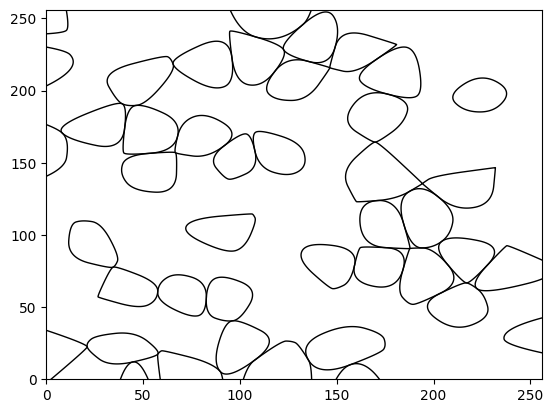

In [281]:
from shapely.ops import voronoi_diagram
from shapely.geometry import MultiPoint, Polygon, Point, GeometryCollection
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from scipy.interpolate import splprep, splev
from shapelysmooth import chaikin_smooth


from typing import Optional, List

class Region:
    polygon: Polygon # Geometrical entity defining this area (boundaries)
    repr: Polygon # Representation of the object contained in this region. (e.g., cell or organelle)
    parent: 'Optional[Region]'
    children: 'List[Region]'
    boundary_size: int

    subdivision_points: List[List[tuple]]
    # Some other properties
    
    def __init__(self, polygon: Polygon, parent: 'Optional[Region]' = None) -> None:
        self.polygon = polygon 
        self.parent = parent
        self.depth = 0
        self.repr=None
        if parent is not None:
            self.parent.add_child(self)
            self.depth = self.parent.depth + 1
        self.children: List[Region] = []

    def __str__(self) -> str:
        return f"Region, Depth {self.depth}, Area {self.polygon.area} Verts: {len(self.polygon.exterior.xy[0])} XY: {self.polygon.exterior.xy} "

    def _poly_coords(self, as_numpy=False):
        """
            Coordinates of the boundaries of this region
        """
        coords = self.polygon.exterior.coords
        if as_numpy:
            return np.array(coords)
        return coords
    
    def _repr_coords(self, as_numpy=False):
        """
            Coordinates of the object inside this region
        """
        coords = self.repr.exterior.coords
        if as_numpy:
            return np.array(coords)
        return coords

    def subdivide_voronoi(self, n_points=8, min_distance=20, center_std=10, distance_from_border=10):
        """
            Generate children regions using voronoi
        """
        # TODO: Save params
        self.subdivision_points = self._sample_points(n_points=n_points, center_std=center_std, min_distance=min_distance, mid_distance_from_edges=distance_from_border)
        voronoi_geometries = voronoi_diagram(MultiPoint(self.subdivision_points), envelope=self.polygon) # FIXME: the envelope seems to be taken as the bounding box of polygon, not the polygon itself
        for poly in voronoi_geometries.geoms:
            Region(polygon=poly, parent=self)

    def represent_smooth(self, prob=1.0, recursive=True):
        """
            Adds a representation using smoothing
        """

        self.repr = chaikin_smooth(self.polygon, 10, False)
        
        if recursive:
            for ch in self.children:
                if np.random.uniform() <= prob:
                    ch.represent_smooth(recursive=True)

    def plot(self, ax=None, plot_repr=True, plot_poly=False):
        """
            Plots the tree of geometrical regions
        """

        
        if self.depth > 0:
            if plot_poly:
                mpl_polygon = MplPolygon(self._poly_coords(as_numpy=True), closed=True, edgecolor='black', facecolor="none")
                ax.add_patch(mpl_polygon)
            if plot_repr and self.repr is not None:
                mpl_polygon = MplPolygon(self._repr_coords(as_numpy=True), closed=True, edgecolor='black', facecolor="none")
                ax.add_patch(mpl_polygon)
            
            
        else:
            fig, ax = plt.subplots()

            # Set axis limits based on the polygon bounds of the root region
            minx, miny, maxx, maxy = self.polygon.bounds
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)

        for ch in self.children:
            ch.plot(ax, plot_repr=plot_repr, plot_poly=plot_poly)

    def add_child(self, other):
        """
        
        """
        self.children.append(other)
    
    def _get_random_point(self, existing_points, min_distance, boundary: Polygon):
        """
            Generates a random point that is ensured to lay whithin the provided boundary.
        """
        while True:
            # Generate random point inside the polygon's bounding box
            minx, miny, maxx, maxy = boundary.bounds
            x = np.random.uniform(minx, maxx)
            y = np.random.uniform(miny, maxy)
            new_point = Point(x, y)

            # Ensure point lies inside the inner polygon and respects the minimum distance
            if boundary.contains(new_point) and all(new_point.distance(p) >= min_distance for p in existing_points):
                return new_point

    def _sample_points(self, n_points, center_std, min_distance, mid_distance_from_edges):
        """
        Samples points inside the current polygon while ensuring that points maintain the specified minimum distance.
        
        Args:
            n_points: Number of points to sample.
            center_std: Standard deviation for jittering the central point.
            min_distance: Minimum distance between points
            mid_distance_from_edges: Minimum distance from the border of the polygon.
        
        Returns:
            List of sampled points.
        """
        # Create an inset polygon that ensures the distance from the border
        inner_polygon = self.polygon.buffer(-mid_distance_from_edges)

        if inner_polygon.is_empty:
            raise ValueError("The polygon is too small to maintain the specified distance from the border.")

        points = []

        # Sample the first point around the polygon's centroid with some jitter
        centroid = inner_polygon.centroid
        x_jittered = np.random.normal(centroid.x, center_std)
        y_jittered = np.random.normal(centroid.y, center_std)
        center_point = Point(x_jittered, y_jittered)

        if inner_polygon.contains(center_point):
            points.append(center_point)
        else:
            points.append(centroid)  # Fallback to centroid if jittered point is out of bounds

        # Sample remaining points
        for _ in range(n_points - 1):
            point = self._get_random_point(points, min_distance, boundary=self.polygon)
            points.append(point)

        return points
    

class CellSimulator:
    size: int  # Image size
    image_boundaries: Polygon

    def __init__(self, size=256) -> None:
        self.size = size
        

    def sample(self, cell_prob=1.0, n_points=8, min_distance=20, center_std=10, distance_from_border=10):
        self.image_boundaries = Polygon([(0, 0), (self.size, 0), (self.size, self.size), (0, self.size)])
        root_region = Region(self.image_boundaries, parent=None)
        root_region.subdivide_voronoi( n_points=n_points, min_distance=min_distance, center_std=center_std, distance_from_border=distance_from_border)
        root_region.represent_smooth(prob=cell_prob)
        return root_region


simulator = CellSimulator()
img = simulator.sample(n_points=100, cell_prob=.5)
img.plot()
plt.show()


AttributeError: 'Polygon' object has no attribute 'geoms'

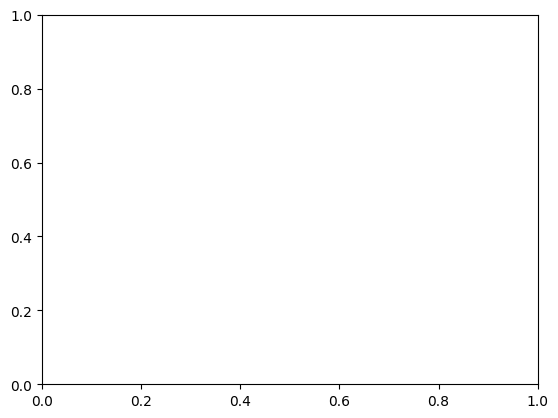

In [78]:
from shapely.ops import voronoi_diagram
from shapely.geometry import MultiPoint, Polygon, Point, GeometryCollection
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from scipy.interpolate import splprep, splev
from shapelysmooth import chaikin_smooth


class VoronoiPartition:
    parent: Polygon  # Parent Polygon (e.g., image boundaries)
    min_distance: int  # Minimum distance between sampled points
    points: list  # Sampled points
    spline: tuple[list, list] # x and y coords of the points composing the spline

    def __init__(self, parent: Polygon, n_points=8, min_distance=20, center_std=10, distance_from_border=10):
        """
        Initializes a Voronoi partition based on a parent polygon, with the sampling process built-in.
        
        Args:
            parent: The Polygon in which to generate the Voronoi partition.
            n_points: Number of points to sample for the partition.
            min_distance: Minimum distance between points.
            center_std: Standard deviation for jittering the center point.
            distance_from_border: Minimum distance each point must maintain from the polygon's borders.
        """
        self.parent = parent
        self.children = None
        self.min_distance = min_distance
        self.points = self._sample_points(n_points, center_std, distance_from_border)
        self.voronoi_regions = voronoi_diagram(MultiPoint(self.points), envelope=self.parent)
        # TODO up to now envelope is just the bounding box of the polygon...?

    def _sample_points(self, n_points, center_std, distance_from_border):
        """
        Samples points inside the parent polygon while ensuring that points maintain the specified minimum distance.
        
        Args:
            n_points: Number of points to sample.
            center_std: Standard deviation for jittering the central point.
            distance_from_border: Minimum distance from the border of the polygon.
        
        Returns:
            List of sampled points.
        """
        # Create an inset polygon that ensures the distance from the border
        inner_polygon = self.parent.buffer(-distance_from_border)

        if inner_polygon.is_empty:
            raise ValueError("The polygon is too small to maintain the specified distance from the border.")

        points = []

        # Sample the first point around the polygon's centroid with some jitter
        centroid = inner_polygon.centroid
        x_jittered = np.random.normal(centroid.x, center_std)
        y_jittered = np.random.normal(centroid.y, center_std)
        center_point = Point(x_jittered, y_jittered)

        if inner_polygon.contains(center_point):
            points.append(center_point)
        else:
            points.append(centroid)  # Fallback to centroid if jittered point is out of bounds

        # Function to generate random points inside the polygon
        def get_random_point(existing_points, min_distance):
            while True:
                # Generate random point inside the polygon's bounding box
                minx, miny, maxx, maxy = inner_polygon.bounds
                x = np.random.uniform(minx, maxx)
                y = np.random.uniform(miny, maxy)
                new_point = Point(x, y)

                # Ensure point lies inside the inner polygon and respects the minimum distance
                if inner_polygon.contains(new_point) and all(new_point.distance(p) >= min_distance for p in existing_points):
                    return new_point

        # Sample remaining points
        for _ in range(n_points - 1):
            point = get_random_point(points, self.min_distance)
            points.append(point)

        return points

    def get_voronoi_regions(self) -> GeometryCollection:
        """
        Returns the generated Voronoi regions.
        """
        return self.voronoi_regions

    # TODO: this shouldn't be here since this class only has reference to the polygon on which voronoi partition is defined, not the inner polygons.
    def shapely_polygon_to_spline(self, polygon, num_points=10, smoothness=0.5):
        """
        Creates a blob within the region defined by the spline
        """
        # points = generate_random_points_within_polygon(polygon, num_points)
        x, y = polygon.exterior.coords.xy
        x = x.tolist()
        y = y.tolist()

        # Interpolate the points using a spline to create a smooth curve
        tck, u = splprep([x, y], s=smoothness, per=True)  # per=True makes the spline periodic (closed)
        u_fine = np.linspace(0, 1, 100)  # 100 points for smoothness
        x_fine, y_fine = splev(u_fine, tck)

        return x_fine, y_fine

    def plot_spline(self, xx, yy):
        # Plotting the resulting blob shape
        plt.plot(xx, yy, 'r-', lw=2)
        plt.fill(xx, yy, alpha=0.4)
    

class CellSimulator:
    size: int  # Image size
    image_boundaries: Polygon

    def __init__(self, size=256) -> None:
        self.size = size
        self.image_boundaries = Polygon([(0, 0), (size, 0), (size, size), (0, size)])

    def create_partition(self, poly=None, n_points=8, min_distance=20, center_std=10, distance_from_border=10):
        """
        Creates a Voronoi partition based on the image boundaries or a provided Polygon
        """
        if poly is None:
            poly = self.image_boundaries

        return VoronoiPartition(poly, n_points, min_distance, center_std, distance_from_border)

    def plot_splines(self, partition: VoronoiPartition) -> None:
        plt.figure()
        # TODO: Move this part in a separate function
        subregions = partition.get_voronoi_regions().geoms

        for poly in subregions:
            # TODO: This is inconsistent with how the classes are defined. Needs refactoring.
            spline = partition.shapely_polygon_to_spline(poly)
            partition.plot_spline(*spline)
        
        plt.show()
    
    def _plot_shapely_polygon(self, ax, poly):
        mpl_polygon = MplPolygon(np.array(poly.exterior.coords), closed=True, edgecolor='black', facecolor=np.random.rand(3,))
        ax.add_patch(mpl_polygon)
            
    def plot_voronoi(self, partition: VoronoiPartition, plot_regions_only=False) -> None:
        """
        Plots the sampled points and Voronoi regions using Matplotlib.
        
        Args:
            partition: VoronoiPartition instance containing sampled points and regions.
        """
        fig, ax = plt.subplots()

        # Plot Voronoi regions
        for cell_region in partition.get_voronoi_regions().geoms:
            
            organelle_partition = self.create_partition(cell_region, 4, min_distance=5, center_std=3)
            
            cell = chaikin_smooth(cell_region, 10, False) if not plot_regions_only else cell_region
            self._plot_shapely_polygon(ax, cell)

            for organelle_region in organelle_partition.get_voronoi_regions().geoms:

                organelle = chaikin_smooth(organelle_region, 2, False) if not plot_regions_only else organelle_region
                self._plot_shapely_polygon(ax, organelle)

                # Convert the Shapely polygon into a Matplotlib polygon and plot it
                

        # Plot points as red dots
        x_coords, y_coords = zip(*[(p.x, p.y) for p in partition.points])
        ax.scatter(x_coords, y_coords, color='red', zorder=5)  # zorder=5 ensures points are on top of the regions

        # Plot the outer boundary
        mpl_outer_polygon = MplPolygon(np.array(partition.parent.exterior.coords), closed=True, edgecolor='blue', fill=False, linewidth=2)
        ax.add_patch(mpl_outer_polygon)

        # Set plot limits and aspect ratio to match the image size
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_aspect('equal')

        plt.show()



# Example usage:
simulator = CellSimulator()

# Create a Voronoi partition based on image boundaries
partition = simulator.create_partition(n_points=8, min_distance=50, center_std=5, distance_from_border=20)

# Plot the results
simulator.plot_voronoi(partition, plot_regions_only=True)
# simulator.plot_splines(partition)

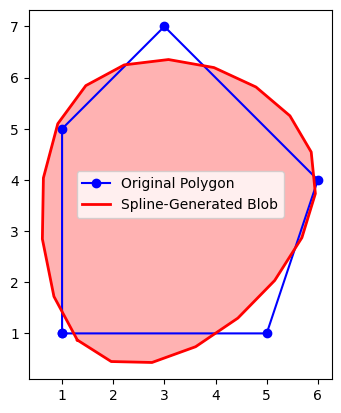

In [314]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.interpolate import splprep, splev

# Define a simple polygon
simple_polygon = Polygon([(1, 1), (5, 1), (6, 4), (3, 7), (1, 5)])

# Extract x and y coordinates from the polygon
x, y = simple_polygon.exterior.coords.xy
x = x.tolist()
y = y.tolist()


# Interpolate the points using a spline to create a smooth curve
tck, u = splprep([x, y], s=1, per=True)  # per=True makes the spline periodic (closed)
u_fine = np.linspace(0, 1, 20)  # Generate 100 points for a smooth curve
x_fine, y_fine = splev(u_fine, tck)

# Plot both the original polygon and the smoothed spline
plt.figure()

# Plot original polygon
plt.plot(x, y, 'bo-', label='Original Polygon')

# Plot spline-interpolated "blob" shape
plt.plot(x_fine, y_fine, 'r-', lw=2, label='Spline-Generated Blob')
plt.fill(x_fine, y_fine, alpha=0.3, color='red')

# Adjust plot settings
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal
plt.show()


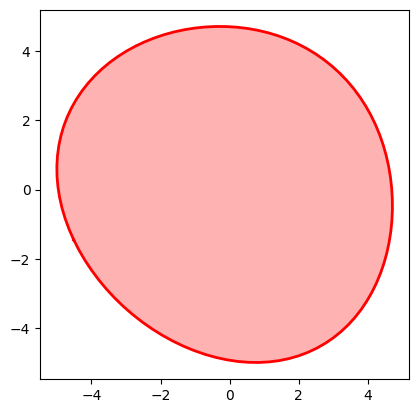

In [620]:
import numpy as np
import matplotlib.pyplot as plt

def random_fourier_blob(n_coefficients=10, num_points=100, radius=5, smoothing_factor=5):
    t = np.linspace(0, 2 * np.pi, num_points)
    x = np.zeros(num_points)
    y = np.zeros(num_points)

    # Generate Fourier coefficients
    for n in range(1, n_coefficients + 1):
        # Add random coefficients for the x and y components
        a_x = np.random.uniform(-1, 1) / n**smoothing_factor
        b_x = np.random.uniform(-1, 1) / n**smoothing_factor
        a_y = np.random.uniform(-1, 1) / n**smoothing_factor
        b_y = np.random.uniform(-1, 1) / n**smoothing_factor
        
        x += a_x * np.cos(n * t) + b_x * np.sin(n * t)
        y += a_y * np.cos(n * t) + b_y * np.sin(n * t)

    # Normalize to the desired radius
    x = radius * x / np.max(np.abs(x))
    y = radius * y / np.max(np.abs(y))

    return x, y

# Generate a random blob using Fourier descriptors
x_blob, y_blob = random_fourier_blob(20)

# Plot the result
plt.plot(x_blob, y_blob, 'r-', lw=2)
plt.fill(x_blob, y_blob, alpha=0.3, color='red')
plt.gca().set_aspect('equal')
plt.show()


In [ ]:
https://pypi.org/project/shapelysmooth/#smoothing-collections-of-geometries

/var/folders/6k/bmxrc4yx7qvcz0jxn0qwv6v00000gp/T/ipykernel_64394/3824116131.py:37: RuntimeWarning: invalid value encountered in divide
  direction = (end - start) / np.linalg.norm(end - start)


<Axes: >

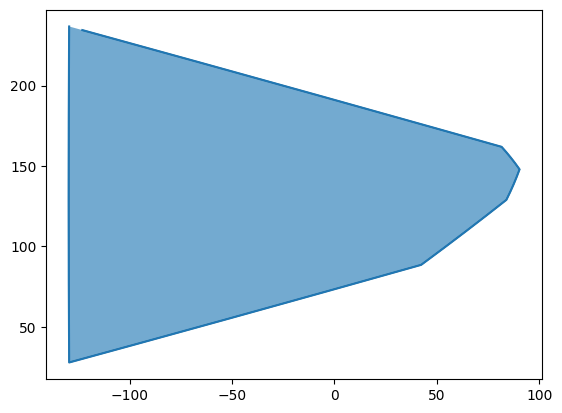

In [38]:
import bezier
import numpy as np

def shapely_polygon_to_bezier(poly):
    # Extract the coordinates of the polygon
    xx, yy = poly.exterior.coords.xy
    
    # Convert the coordinates to a numpy array of Fortran order
    nodes = np.asfortranarray([xx, yy])
    
    # Initialize a list to store edges
    edges = []
    
    # Create edges by connecting each consecutive point
    for i in range(len(nodes[0]) - 1):  # last point connects back to the first
        if i < len(nodes[0]) - 1:
            edge = bezier.Curve(nodes[:, i:i + 2], degree=1)  # linear edge
        else:
            edge = bezier.Curve(np.column_stack((nodes[:, -1], nodes[:, 0])), degree=2)  # closing edge
        edges.append(edge)

    # Create a CurvedPolygon from the edges
    curved_poly = bezier.CurvedPolygon(*edges)
    
    return curved_poly

shapely_polygon_to_bezier(region).plot(34)

array('d', [-129.50487804947696, 81.55827302334204, 90.32632983625373, 83.88957273287497, 42.28969488356763, -129.50487804947696, -129.50487804947696])
[-129.50487804947696, -129.50487804947696, 42.28969488356763, 83.88957273287497, 90.32632983625373, 81.55827302334204, -129.50487804947696]
Edge 0: [[-129.50487805 -133.12764944 -129.50487805]
 [ 236.70492932  133.23725054   27.9249052 ]]
Edge 1: [[-129.50487805  -45.07354755   42.28969488]
 [  27.9249052    57.43801302   88.57717219]]
Edge 2: [[ 42.28969488  62.32402082  83.88957273]
 [ 88.57717219 107.66903879 128.96153062]]
Edge 3: [[ 83.88957273  88.31260743  90.32632984]
 [128.96153062 133.33885104 147.91299253]]
Edge 4: [[ 90.32632984  64.3420936   81.55827302]
 [147.91299253 163.11861289 161.92490841]]
Edge 5: [[  81.55827302   -7.14818816 -129.50487805]
 [ 161.92490841  193.35375323  236.70492932]]


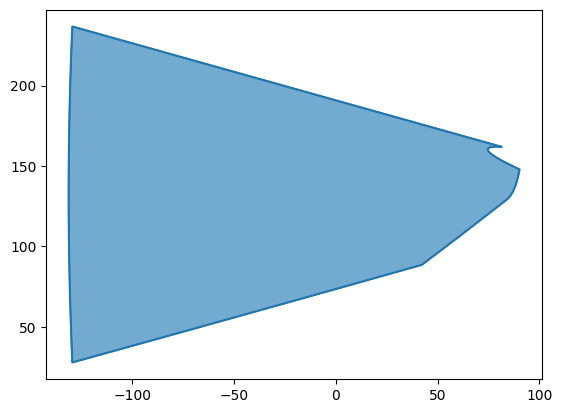

In [343]:
import bezier
import numpy as np
from shapely.geometry import Polygon

def shapely_polygon_to_bezier(poly, degree=1, control_modifiers=None):
    """
    Convert a shapely polygon to a bezier curved polygon.
    
    Parameters:
        poly: The input shapely polygon
        degree: Degree of the Bézier curve (1 = linear, 2 = quadratic, 3 = cubic)
        control_modifiers: Array to modify control points for each edge. 
                           For quadratic, it should have 1 value per edge.
                           For cubic, it should have 2 values per edge.
    """
    xx, yy = poly.exterior.coords.xy
    print(xx)
    xx = list(reversed(xx))
    print(xx)
    yy = list(reversed(yy))
    vertices = np.array([xx, yy])
    num_vertices = vertices.shape[1]
    
    # Set default control modifiers if not provided
    if control_modifiers is None:
        control_modifiers = np.zeros((num_vertices, degree - 1))  # Default to no modification
    
    edges = []

    # Create edges for the polygon
    for i in range(num_vertices - 1):  # Handling edges between vertices
        start = vertices[:, i]
        end = vertices[:, (i + 1) % num_vertices]
        #print(start, end)
        if degree == 1:
            # Linear curve (straight line between two points)
            edge = bezier.Curve(np.asfortranarray([start, end]).T, degree=1)
        
        elif degree == 2:
            # Quadratic Bézier curve (needs 3 control points: start, control, end)
            control = get_control_point(start, end, vertices[:, (i + 2) % num_vertices], control_modifiers[i, 0])
            edge = bezier.Curve(np.asfortranarray([start, control, end]).T, degree=2)
        
        elif degree == 3:
            # Cubic Bézier curve (needs 4 control points: start, 2 controls, end)
            control1 = get_control_point(start, end, vertices[:, (i + 2) % num_vertices], control_modifiers[i, 0])
            control2 = get_control_point(end, start, vertices[:, (i + 3) % num_vertices], control_modifiers[i, 1])
            edge = bezier.Curve(np.asfortranarray([start, control1, control2, end]).T, degree=3)
        
        edges.append(edge)
        

    # Create a CurvedPolygon from the edges
    for e, eg in enumerate(edges):
        print(f"Edge {e}: {eg.nodes}")
    curved_poly = bezier.CurvedPolygon(*edges)
    return curved_poly

def get_control_point(start, end, next_point, modifier):
    """
    Calculate a control point between start and end, with a 'modifier' to adjust its position.
    
    The 'modifier' determines how far to push the control point inward or outward from the polygon.
    """
    mid_point = (start + end) / 2  # Midpoint between the start and end
    direction = (next_point - mid_point)  # Vector pointing to next vertex
    norm_direction = direction / np.linalg.norm(direction)  # Normalize the direction

    # Modify control point based on the 'modifier' value
    control_point = mid_point + modifier * norm_direction
    return control_point


# Example usage
if __name__ == "__main__":
    degree = 2
    #region = Polygon([(0, 0), (2, 0), (3, 2), (1, 3), (-1, 2)])
    cm = np.asarray([ [20*np.random.normal() for d in range(degree - 1)] for v in region.exterior.xy[0]])
    shapely_polygon_to_bezier(region, degree=degree, control_modifiers=cm).plot(40)


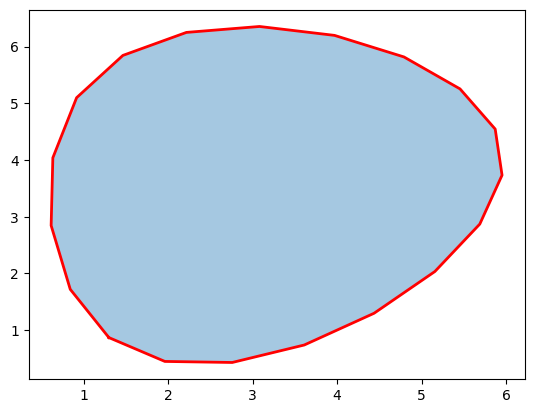

In [352]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.interpolate import splprep, splev

# Generate a random set of points within the polygon
def generate_random_points_within_polygon(polygon, num_points=10):
    min_x, min_y, max_x, max_y = polygon.bounds
    points = []
    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if polygon.contains(random_point):
            points.append(random_point)
    return points

# Create a smooth blob shape by interpolating the random points using a spline
def create_blob_shape(polygon, num_points=10, smoothness=0.5):


    # Plotting the resulting blob shape
    plt.plot(x_fine, y_fine, 'r-', lw=2)
    plt.fill(x_fine, y_fine, alpha=0.4)
    plt.show()

# Example of using the function within a polygon
create_blob_shape(region, num_points=50, smoothness=1.0)  # Smoothness controls how curvy the shape is


In [ ]:
def shapely_polygon_to_spline(polygon, num_points=10, smoothness=0.5):
    """
    Creates a blob within the region defined by the spline
    """
    # points = generate_random_points_within_polygon(polygon, num_points)
    x, y = polygon.exterior.coords.xy
    x = x.tolist()
    y = y.tolist()

    # Close the shape by appending the first point at the end
    #x.append(x[0])
    #y.append(y[0])

    # Interpolate the points using a spline to create a smooth curve
    tck, u = splprep([x, y], s=smoothness, per=True)  # per=True makes the spline periodic (closed)
    u_fine = np.linspace(0, 1, 100)  # 100 points for smoothness
    x_fine, y_fine = splev(u_fine, tck)

    return x_fine, y_fine

def plot_spline(xx, yy):
    # Plotting the resulting blob shape
    plt.plot(xx, yy, 'r-', lw=2)
    plt.fill(xx, yy, alpha=0.4)
    plt.show()
